In [67]:
import pandas as pd
import json
import os 
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches

In [68]:
ids = []
for file_name in os.listdir('../haystack/irrelevant'):
    if file_name.endswith('.txt'):
        file_id = os.path.splitext(file_name)[0]  # Extract the file name without extension
        ids.append(file_id)
print(ids)

['1', '11', '121', '122', '123', '124', '14', '15', '155', '16', '160', '163', '164', '167', '168', '17', '170', '172', '173', '175', '18', '180', '182', '183', '185', '189', '192', '193', '196', '198', '2', '29', '3', '380', '391', '393', '396', '4', '401', '403', '408', '409', '410', '411', '420', '421', '422', '423', '424', '427', '43', '430', '432', '433', '435', '436', '437', '438', '439', '44', '441', '442', '444', '448', '449', '453', '5', '532', '535', '539', '576', '577', '578', '579', '586', '587', '588', '589', '590', '92', '95', '96']


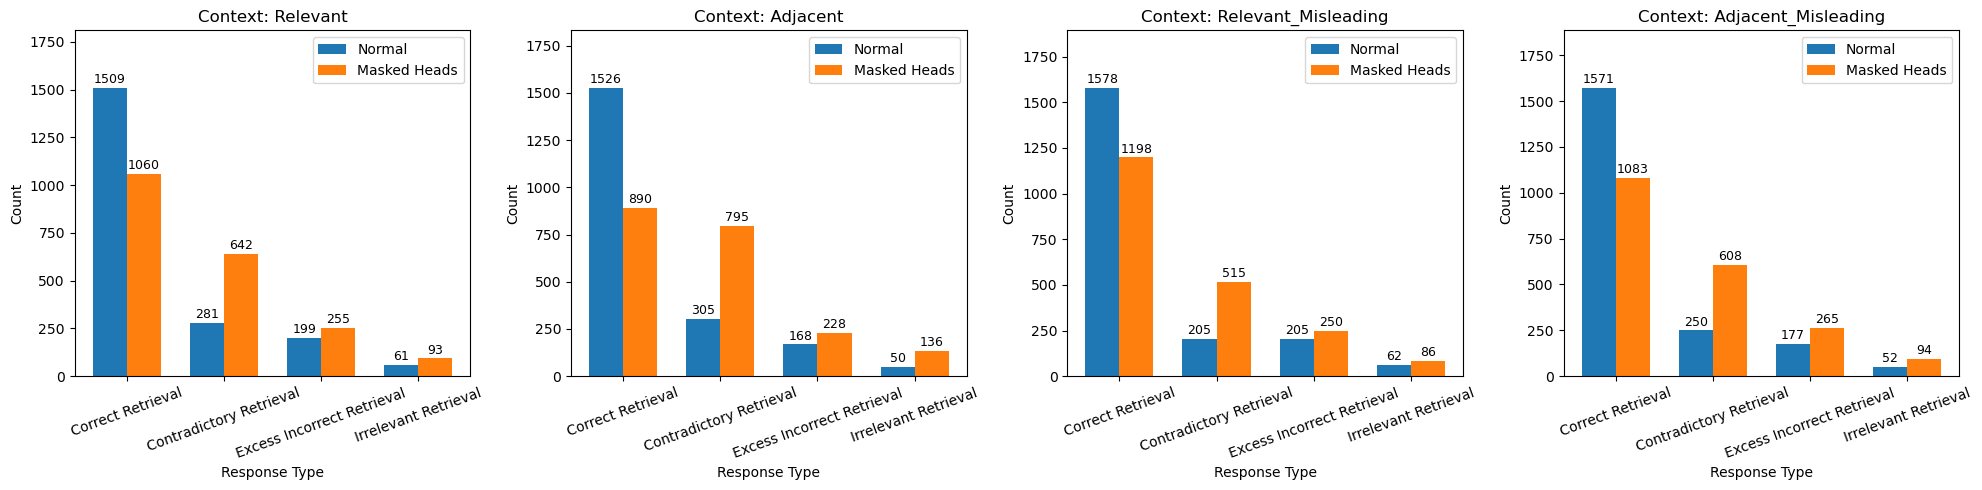

In [ ]:
all_rows_block = []
all_rows_normal = []

for id in ids:
    try:
        with open(f"updated_unique_responses_block_top30/{id}.json", "r") as f:
            data = json.load(f)
            for category, entries in data.items():
                for entry in entries:
                    entry['context_category'] = category
                    entry['id'] = id
                    all_rows_block.append(entry)

        with open(f"updated_unique_responses/{id}.json", "r") as f_non:
            data = json.load(f_non)
            for category, entries in data.items():
                for entry in entries:
                    entry['context_category'] = category
                    entry['id'] = id
                    all_rows_normal.append(entry)

    except FileNotFoundError:
            pass
    
df_block = pd.DataFrame(all_rows_block)
df_normal = pd.DataFrame(all_rows_normal)
#df = pd.DataFrame(all_rows)
df_block['scores'] = df_block['hallucination_type'].apply(
    lambda x: 100.0 if x == 'Correct Retrieval' else 0.0
)
df_normal['scores'] = df_normal['hallucination_type'].apply(
    lambda x: 100.0 if x == 'Correct Retrieval' else 0.0
)

# row: depth, col: context length
depth_percentages_set_block = set(df_block['depth_percent'])
context_length_set_block = set(df_block['context_length'])
depth_percentages_set_normal = set(df_normal['depth_percent'])
context_length_set_normal = set(df_normal['context_length'])

score_matrix_block = pd.DataFrame(0.0, index=sorted(list(depth_percentages_set_block)), columns=sorted(list(context_length_set_block)))
score_matrix_normal = pd.DataFrame(0.0, index=sorted(list(depth_percentages_set_normal)), columns=sorted(list(context_length_set_normal)))

score_mean_block_matrices = {
    "irrelevant": score_matrix_block.copy(),
    "relevant": score_matrix_block.copy(),
    "relevant_misleading": score_matrix_block.copy(),
    "irrelevant_misleading": score_matrix_block.copy()
}

score_mean_normal_matrices = {
    "irrelevant": score_matrix_normal.copy(),
    "relevant": score_matrix_normal.copy(),
    "relevant_misleading": score_matrix_normal.copy(),
    "irrelevant_misleading": score_matrix_normal.copy()
}

bar_charts = {
    "relevant": None,
    "irrelevant": None,
    "relevant_misleading": None,
    "irrelevant_misleading": None
}
     
for context_key in score_mean_block_matrices.keys():
    bar_chart_df = df_block[df_block['context_category'] == context_key]
    hallucination_counts = bar_chart_df['hallucination_type'].value_counts().to_dict()
    bar_charts[context_key] = defaultdict(lambda: 0, hallucination_counts)
    
    for depth in depth_percentages_set_block:
        for context_length in context_length_set_block:
            filtered_df = df_block[(df_block['depth_percent'] == depth) & (df_block['context_length'] == context_length) & (df_block['context_category'] == context_key)]

            if not filtered_df.empty:
                avg_val = filtered_df['scores'].mean()
                # using population variance
                var_val = filtered_df['scores'].var(ddof=0)
                score_mean_block_matrices[context_key].loc[depth, context_length] = avg_val

diff_dict = {}
for context_key in score_mean_normal_matrices.keys():
    bar_chart_df = df_normal[df_normal['context_category'] == context_key]
    hallucination_counts = bar_chart_df['hallucination_type'].value_counts().to_dict()
    bar_charts[context_key] = defaultdict(lambda: 0, hallucination_counts)
    
    for depth in depth_percentages_set_normal:
        for context_length in context_length_set_normal:
            filtered_df = df_normal[(df_normal['depth_percent'] == depth) & (df_normal['context_length'] == context_length) & (df_normal['context_category'] == context_key)]
            if not filtered_df.empty:
                avg_val = filtered_df['scores'].mean()
                # using population variance
                var_val = filtered_df['scores'].var(ddof=0)
                score_mean_normal_matrices[context_key].loc[depth, context_length] = avg_val
    
    diff_dict[context_key] = ((score_mean_normal_matrices[context_key] - score_mean_block_matrices[context_key]) / score_mean_normal_matrices[context_key] ) * 100.0


                
# Rebuild bar_charts to separate normal and block
bar_charts_combined = {
    context_key: {
        "normal": defaultdict(lambda: 0, df_normal[df_normal['context_category'] == context_key]['hallucination_type'].value_counts().to_dict()),
        "block": defaultdict(lambda: 0, df_block[df_block['context_category'] == context_key]['hallucination_type'].value_counts().to_dict())
    }
    for context_key in ["relevant", "irrelevant", "relevant_misleading", "irrelevant_misleading"]
}

# Plot grouped bar chart
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.flatten()

x_labels = ["Correct Retrieval", "Contradictory Retrieval", "Excess Incorrect Retrieval", "Irrelevant Retrieval"]
x = range(len(x_labels))
bar_width = 0.35

context_title_map = {
    "relevant": "Relevant",
    "irrelevant": "Adjacent",
    "relevant_misleading": "Relevant_Misleading",
    "irrelevant_misleading": "Adjacent_Misleading"
}


for idx, (context_key, context_data) in enumerate(bar_charts_combined.items()):
    ax = axes[idx]
    
    normal_counts = [context_data["normal"][label] for label in x_labels]
    block_counts = [context_data["block"][label] for label in x_labels]

    bar1 = ax.bar([i - bar_width/2 for i in x], normal_counts, width=bar_width, label='Normal')
    bar2 = ax.bar([i + bar_width/2 for i in x], block_counts, width=bar_width, label='Masked Heads')

    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=20)
    ax.set_xlabel("Response Type")
    ax.set_ylabel("Count")
    #ax.set_title("Context: " + context_key.capitalize())
    ax.set_title("Context: " + context_title_map[context_key])
    ax.set_ylim(0, max(max(normal_counts), max(block_counts)) * 1.2)
    ax.legend()

    # Annotate bars
    for bars in [bar1, bar2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 10, str(int(height)),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



In [70]:
CONTEXTS = ['relevant', 'irrelevant', 'relevant_misleading', 'irrelevant_misleading']
dfs = [(context, pd.DataFrame(diff_dict[context])) for context in CONTEXTS]
pivot_tables = []
for k, df in dfs:
    print(df)
    df = df.reset_index().melt(id_vars='index', var_name='context_length', value_name='score')
    df = df.rename(columns={'index': 'depth_percentage'})  
    print(df)
    pivot_table = pd.pivot_table(df, values='score', index=['depth_percentage', 'context_length'], aggfunc='mean').reset_index()
    pivot_table = pivot_table.pivot(index="depth_percentage", columns="context_length", values="score")
    pivot_tables.append((k, pivot_table))


            0          1250       2500       3750       5000
0.0    33.802817  35.000000  27.777778  35.000000  31.428571
25.0   32.857143  36.363636  27.450980  35.000000  37.500000
50.0   32.857143  30.909091  29.230769  33.898305  36.764706
75.0   31.428571  28.333333  23.728814  29.508197  36.666667
100.0  32.857143  22.222222  17.808219  17.808219  16.666667
    depth_percentage context_length      score
0                0.0              0  33.802817
1               25.0              0  32.857143
2               50.0              0  32.857143
3               75.0              0  31.428571
4              100.0              0  32.857143
5                0.0           1250  35.000000
6               25.0           1250  36.363636
7               50.0           1250  30.909091
8               75.0           1250  28.333333
9              100.0           1250  22.222222
10               0.0           2500  27.777778
11              25.0           2500  27.450980
12              50.0   

In [71]:
# CONTEXTS = ['relevant', 'irrelevant', 'relevant_misleading', 'irrelevant_misleading']
# dfs = [(context, pd.DataFrame(score_mean_normal_matrices[context])) for context in CONTEXTS]
# pivot_tables = []
# for k, df in dfs:
#     print(df)
#     df = df.reset_index().melt(id_vars='index', var_name='context_length', value_name='score')
#     df = df.rename(columns={'index': 'depth_percentage'})  
#     print(df)
#     pivot_table = pd.pivot_table(df, values='score', index=['depth_percentage', 'context_length'], aggfunc='mean').reset_index()
#     pivot_table = pivot_table.pivot(index="depth_percentage", columns="context_length", values="score")
#     pivot_tables.append((k, pivot_table))


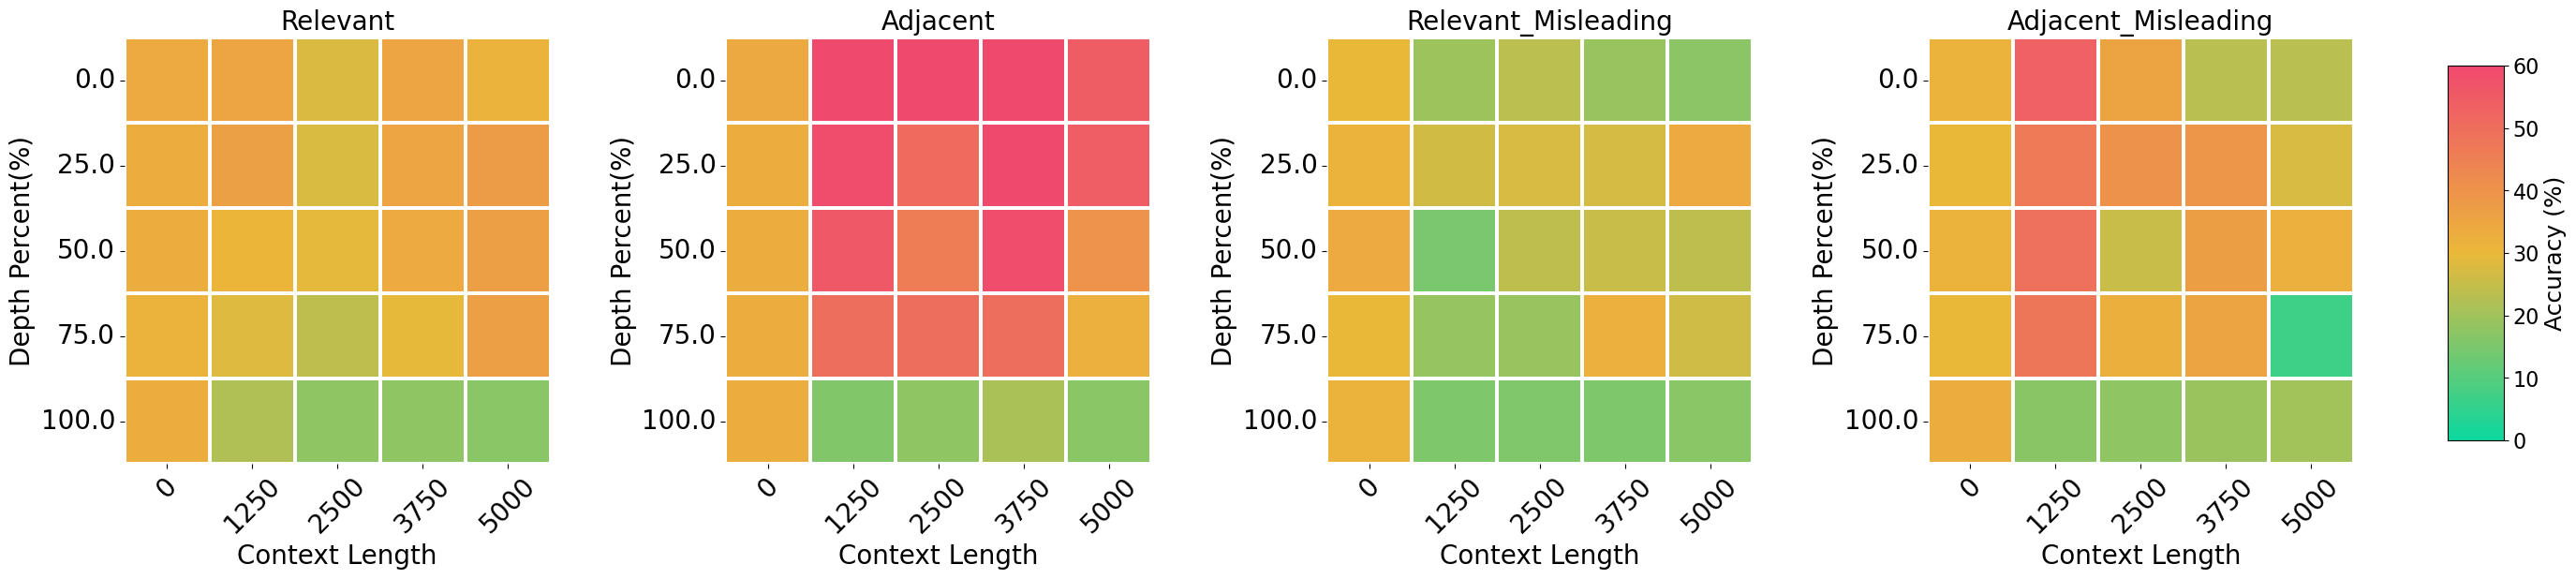

In [73]:
# Set up the figure with 4 rows and 1 column
fig, axes = plt.subplots(1, 4, figsize=(30, 5))  # adjust width as needed
axes = axes.flatten()

# Define custom colormap
# # Normal Score means
# cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])
# max_score = 100

# Diff Score means
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#0CD79F", "#EBB839","#F0496E" ])
max_score = 60

# Plot heatmaps without individual colorbars
for i, (title, data) in enumerate(pivot_tables):
    ax = axes[i]
    hm = sns.heatmap(
        data,
        cmap=cmap,
        vmin=0,
        vmax=max_score,
        square=True,
        linewidths=1.5,
        linecolor='white',
        cbar=False,  # Shared colorbar instead
        ax=ax
    )
    ax.set_title(context_title_map.get(title, title), fontsize=20)
    #ax.set_title(title, fontsize=20)
    ax.set_xlabel('Context Length', fontsize=20)
    ax.set_ylabel('Depth Percent(%)', fontsize=20)
    ax.tick_params(axis='x', rotation=45, labelsize=20)
    ax.tick_params(axis='y', rotation=0, labelsize=20)

# Add shared colorbar
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
#cbar_ax = fig.add_axes([0.6, 0.3, 0.02, 0.4])
cbar = fig.colorbar(hm.get_children()[0], cax=cbar_ax)
cbar.set_label('Accuracy (%)', fontsize=18)
cbar.ax.tick_params(labelsize=16)

# Adjust spacing between subplots, avoid tight_layout
fig.subplots_adjust(left=0.08, right=0.9, top=0.96, bottom=0.05, hspace=0.8)

plt.show()
